# Data Exploration and Cleanup

## Air Quality Data

In [267]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import os
import datetime
from pprint import pprint
import plotly.express as px
from scipy.stats import linregress
from pandas_profiling import ProfileReport

In [20]:
# open the air quality data folder
parent_folder = 'air_quality_data'
csv_list = [f for f in os.listdir(parent_folder) if '.csv' in f]
df_list = []
for csv in csv_list:
    df = pd.read_csv(os.path.join(parent_folder, csv))
    df_list.append(df)
master_df = pd.concat(df_list, ignore_index=True)

In [21]:
master_df.head()

Date Country    City Specie  count  min   max  median  variance
0   6/01/2015      KR  Jeonju     co    124  0.1  12.3     4.5     55.74
1  22/01/2015      KR  Jeonju     co    116  4.5  10.0     6.7     16.09
2  30/03/2015      KR  Jeonju     co    118  1.2  11.2     5.6     35.98
3  27/05/2015      KR  Jeonju     co     93  2.3   5.6     3.4      6.54
4   3/02/2015      KR  Jeonju     co    133  4.5  13.4     7.8     39.24

In [22]:
# Display an overview of the number of rows each Specie has in the dataframe
master_df["Specie"].value_counts()

no2              757103
pm25             751747
pm10             739799
o3               719427
so2              630605
co               577117
temperature      563323
humidity         563167
pressure         560354
wind-speed       508685
dew              407564
wind-gust        312681
precipitation     55443
wind speed        49751
wd                47936
wind gust         31765
aqi               25188
uvi               17841
pol                4958
pm1                2973
neph               2321
d                  2031
mepaqi             1690
psi                 363
Name: Specie, dtype: int64

In [23]:
# remove useless species to our analysisµ
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "aqi", "uvi", "pol", "pm1", "mepaqi", "neph", "d", "psi"]

air_quality_df = master_df[~master_df["Specie"].isin(species_to_remove)].reset_index(drop=True).copy()
# Overview of the remaining air pollutant species in focus
air_quality_df["Specie"].value_counts()

no2     757103
pm25    751747
pm10    739799
o3      719427
so2     630605
co      577117
Name: Specie, dtype: int64

In [24]:
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175798 entries, 0 to 4175797
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Date      object 
 1   Country   object 
 2   City      object 
 3   Specie    object 
 4   count     int64  
 5   min       float64
 6   max       float64
 7   median    float64
 8   variance  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 286.7+ MB


In [55]:
# Change the type of Date 
air_quality_df['Date'] = pd.to_datetime(air_quality_df['Date'], format='%d/%m/%Y')

In [56]:
# Double check the Date data type
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175798 entries, 0 to 4175797
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Date      datetime64[ns]
 1   Country   object        
 2   City      object        
 3   Specie    object        
 4   count     int64         
 5   min       float64       
 6   max       float64       
 7   median    float64       
 8   variance  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 286.7+ MB


In [57]:
# Find the earliest date the air quality dataset covers:
air_quality_df["Date"].min()

Timestamp('2014-12-29 00:00:00')

In [58]:
# Find the latest date the air quality dataset covers:
air_quality_df["Date"].max()

Timestamp('2021-12-06 00:00:00')

In [59]:
# Because we only focus on air data from 2019 to 2020H1,
# we'll remove the few data points on 2018-12-31 and the first days of July 2020.
clean_air_df = air_quality_df[(air_quality_df["Date"] >= pd.to_datetime("2019-01-01")) & (air_quality_df["Date"] <= pd.to_datetime("2020-07-01"))].copy()
clean_air_df.head()

Date Country       City Specie  count    min    max  median  \
1645337 2019-01-16      AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1645338 2019-01-22      AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
1645339 2019-01-26      AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
1645340 2019-07-01      AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
1645341 2019-10-01      AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

         variance  
1645337    179.40  
1645338     23.75  
1645339    941.96  
1645340   1006.88  
1645341     57.97

In [60]:
# Set the starting date for the air quality analysis
starting_date = clean_air_df["Date"].min()
starting_date

Timestamp('2019-01-01 00:00:00')

In [61]:
# Set the cutoff date for the air quality analysis
end_date = clean_air_df["Date"].max()
end_date

Timestamp('2020-07-01 00:00:00')

In [62]:
# Display an overview of the Country column
print(clean_air_df["Country"].unique())
print(clean_air_df["Country"].nunique())

['AE' 'CZ' 'SG' 'AT' 'BE' 'KR' 'MN' 'NO' 'NP' 'PE' 'BA' 'BR' 'IL' 'IN'
 'IR' 'NZ' 'UA' 'US' 'FR' 'KW' 'RE' 'TR' 'XK' 'UZ' 'FI' 'JP' 'KZ' 'RO'
 'RU' 'SK' 'ES' 'HK' 'HR' 'TH' 'LK' 'AR' 'CA' 'CH' 'CL' 'ET' 'KG' 'CW'
 'DE' 'MX' 'SA' 'UG' 'BD' 'HU' 'IS' 'PH' 'ID' 'MO' 'SE' 'SV' 'VN' 'AU'
 'BH' 'GB' 'IE' 'LA' 'LT' 'PR' 'PT' 'TW' 'CN' 'PL' 'BG' 'CY' 'IQ' 'MK'
 'BO' 'DK' 'EC' 'ZA' 'CO' 'EE' 'IT' 'JO' 'NL' 'RS' 'PK' 'TJ' 'MM' 'DZ'
 'TM' 'AF' 'GR' 'ML' 'GE' 'GT' 'CR' 'GN' 'CI' 'GH']
94


In [63]:
# Display an overview of the City column
print(clean_air_df["City"].unique())
print(clean_air_df["City"].nunique())

['Abu Dhabi' 'Dubai' 'Prague' 'Ostrava' 'Brno' 'Pilsen' 'Olomouc'
 'Singapore' 'Salzburg' 'Linz' 'Innsbruck' 'Vienna' 'Graz' 'Liège'
 'Brussels' 'Charleroi' 'Gent' 'Namur' 'Antwerpen' 'Jeonju' 'Seoul'
 'Busan' 'Sejong' 'Ulsan' 'Yeosu' 'Gwangju' 'Seongnam-si' 'Daejeon'
 'Pohang' 'Changwon' 'Suwon' 'Cheongju-si' 'Chuncheon' 'Daegu' 'Jeju City'
 'Incheon' 'Suncheon' 'Mokpo' 'Andong' 'Ulan Bator' 'Trondheim' 'Oslo'
 'Stavanger' 'Bergen' 'Kathmandu' 'Pokhara' 'Lima' 'Sarajevo' 'Zenica'
 'Tuzla' 'São José dos Campos' 'São Paulo' 'Tel Aviv' 'Haifa' 'Jerusalem'
 'Ashdod' 'Netanya' 'Ashkelon' 'Petaẖ Tiqwa' 'New Delhi' 'Hyderabad'
 'Delhi' 'Chandigarh' 'Bhopal' 'Lucknow' 'Ghāziābād' 'Hāpur' 'Gandhinagar'
 'Chennai' 'Nashik' 'Visakhapatnam' 'Mumbai' 'Jaipur' 'Patna'
 'Muzaffarnagar' 'Thiruvananthapuram' 'Bengaluru' 'Kolkata' 'Isfahan'
 'Arāk' 'Karaj' 'Qom' 'Orūmīyeh' 'Yazd' 'Īlām' 'Kerman' 'Khorramshahr'
 'Tabriz' 'Sanandaj' 'Kermanshah' 'Khorramabad' 'Shiraz' 'Zanjān'
 'Mashhad' 'Tehran' 'Auckla

In [64]:
# number of instances in each US city
clean_air_df.loc[clean_air_df["Country"] == "US", "City"].value_counts()

Phoenix            3421
Jacksonville       3393
Tucson             3389
Milwaukee          3377
Denver             3339
Albuquerque        3276
Las Vegas          3272
Atlanta            3169
Fresno             3151
Saint Paul         3150
Chicago            3134
Los Angeles        3086
San Jose           3075
Indianapolis       3015
Boise              2993
Raleigh            2871
Hartford           2860
Oklahoma City      2857
Portland           2816
San Francisco      2812
Washington D.C.    2789
Seattle            2760
Oakland            2758
Boston             2604
Staten Island      2553
Philadelphia       2496
Miami              2470
Jackson            2447
Omaha              2394
Baltimore          2385
Providence         2382
Richmond           2381
Honolulu           2369
El Paso            2288
Manhattan          2288
Salt Lake City     2275
Queens             2272
Detroit            2170
Brooklyn           2104
The Bronx          2091
Sacramento         2073
Columbus        

In [65]:
# Attributes of the cleaned air dataframe
clean_air_df.head()

Date Country       City Specie  count    min    max  median  \
1645337 2019-01-16      AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1645338 2019-01-22      AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
1645339 2019-01-26      AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
1645340 2019-07-01      AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
1645341 2019-10-01      AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

         variance  
1645337    179.40  
1645338     23.75  
1645339    941.96  
1645340   1006.88  
1645341     57.97

In [66]:
# Transpose the clean_air_df so that the species will become the columns.
clean_air_df_transposed = clean_air_df.pivot_table(
    index=["Date", "Country", "City"], columns="Specie", values="median").copy()
clean_air_df_transposed.reset_index(inplace=True)
clean_air_df_transposed.head()

Specie       Date Country       City   co   no2  o3  pm10   pm25   so2
0      2019-01-01      AE  Abu Dhabi  NaN   NaN NaN   NaN  122.0   NaN
1      2019-01-01      AT       Graz  0.1  14.2 NaN  30.0    NaN   1.6
2      2019-01-01      AT  Innsbruck  0.1  21.1 NaN  31.0    NaN   1.1
3      2019-01-01      AT       Linz  0.1   6.9 NaN  10.0   34.0  11.7
4      2019-01-01      AT   Salzburg  0.1  12.4 NaN  13.0    NaN   1.1

In [152]:
clean_air_df_transposed.shape

(307832, 10)

In [147]:
# Create a new column that captures month of each year
clean_air_df_transposed['year_month'] = clean_air_df_transposed["Date"].dt.to_period("M")
clean_air_df_transposed.head()

Specie       Date Country       City   co   no2  o3  pm10   pm25   so2  \
0      2019-01-01      AE  Abu Dhabi  NaN   NaN NaN   NaN  122.0   NaN   
1      2019-01-01      AT       Graz  0.1  14.2 NaN  30.0    NaN   1.6   
2      2019-01-01      AT  Innsbruck  0.1  21.1 NaN  31.0    NaN   1.1   
3      2019-01-01      AT       Linz  0.1   6.9 NaN  10.0   34.0  11.7   
4      2019-01-01      AT   Salzburg  0.1  12.4 NaN  13.0    NaN   1.1   

Specie year_month  
0         2019-01  
1         2019-01  
2         2019-01  
3         2019-01  
4         2019-01

In [68]:
# Define a function to draw boxplots showing monthly distribution of median values
# of different air pollutants across 2019 and 2020H1 (January - July)
def specie_boxplot(specie):
    fig, ax = plt.subplots(figsize=(16, 20))

    green_square = dict(markerfacecolor='g', marker='s', alpha=0.2)
    sns.boxplot(data=clean_air_df_transposed, x='year_month', y=specie, flierprops=green_square)

    plt.xlabel("Year_Month", fontsize=16)
    plt.ylabel(specie, fontsize=16)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.title(
        f"Monthly Distribution of Median {specie} in 94 countries in 2019-2020H1", fontsize=20)
    plt.savefig(f"images/boxplot_{specie}.png")

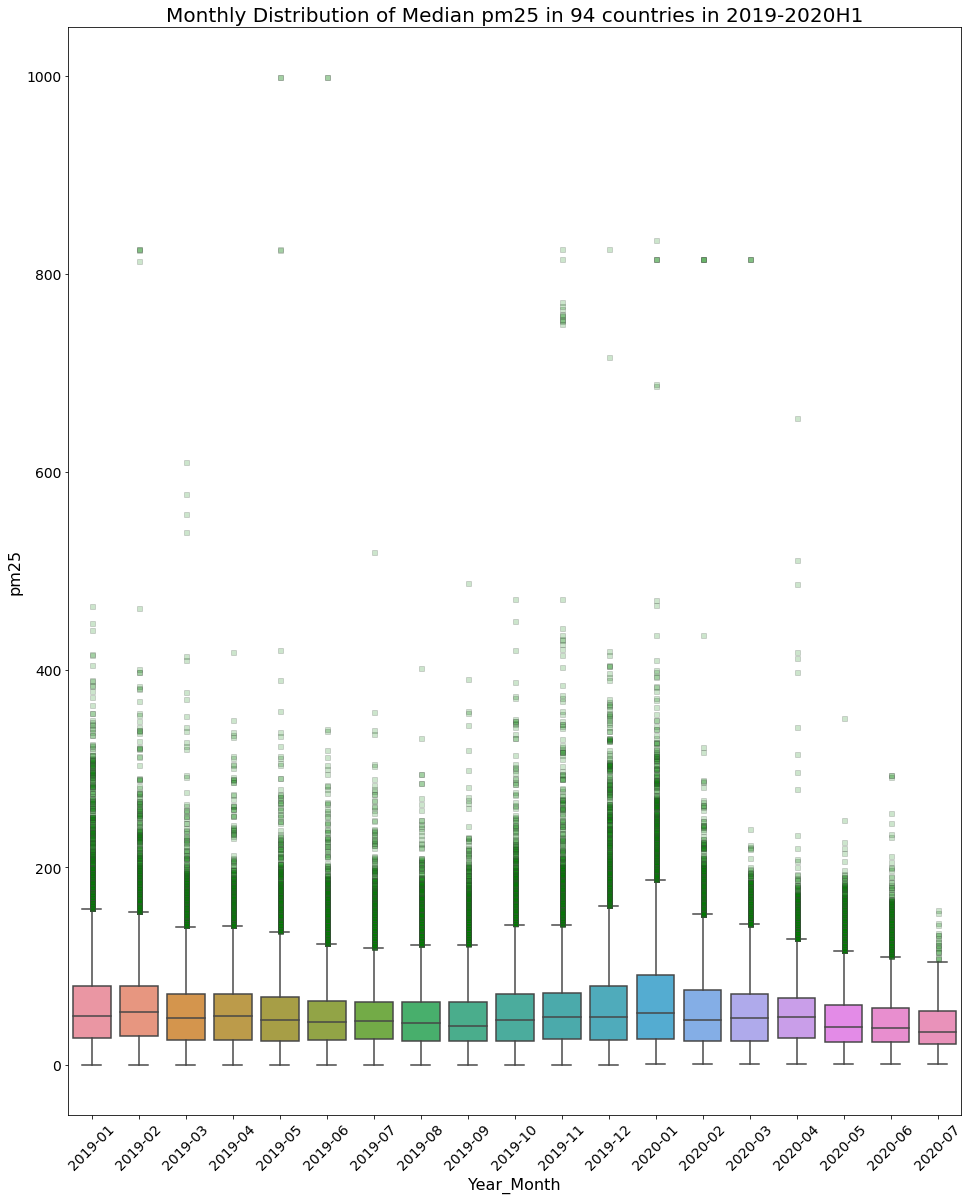

In [69]:
specie_boxplot("pm25")

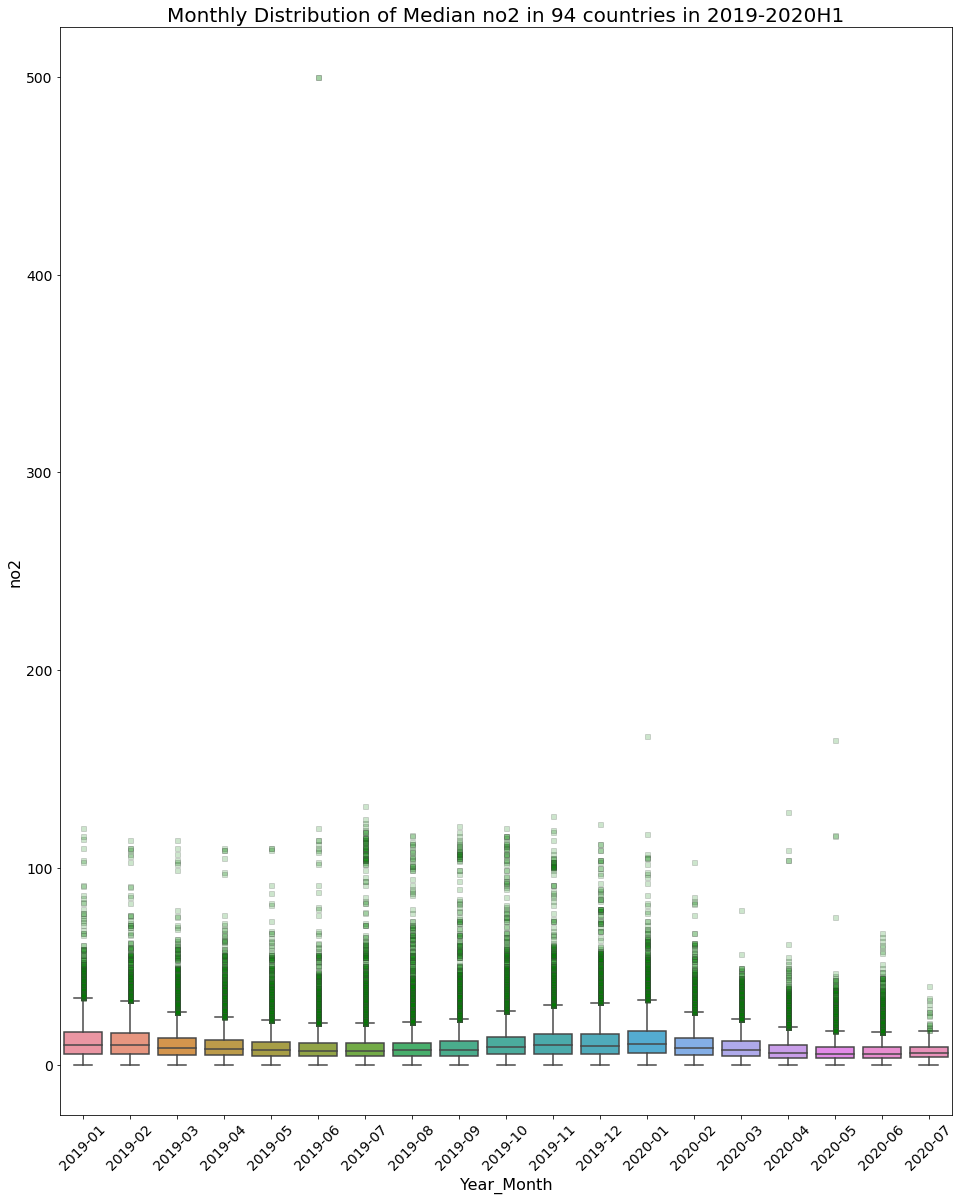

In [70]:
specie_boxplot("no2")

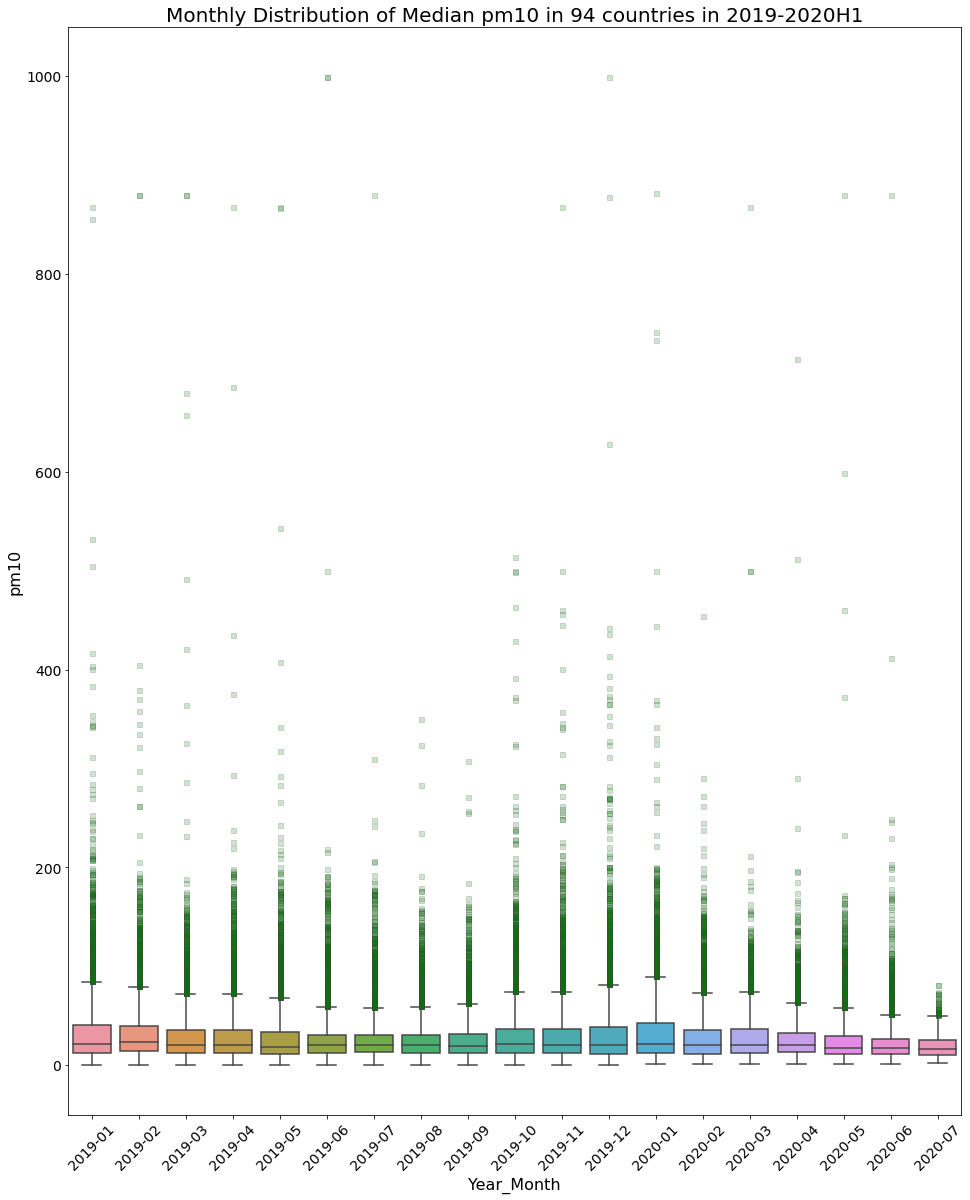

In [71]:
specie_boxplot("pm10")

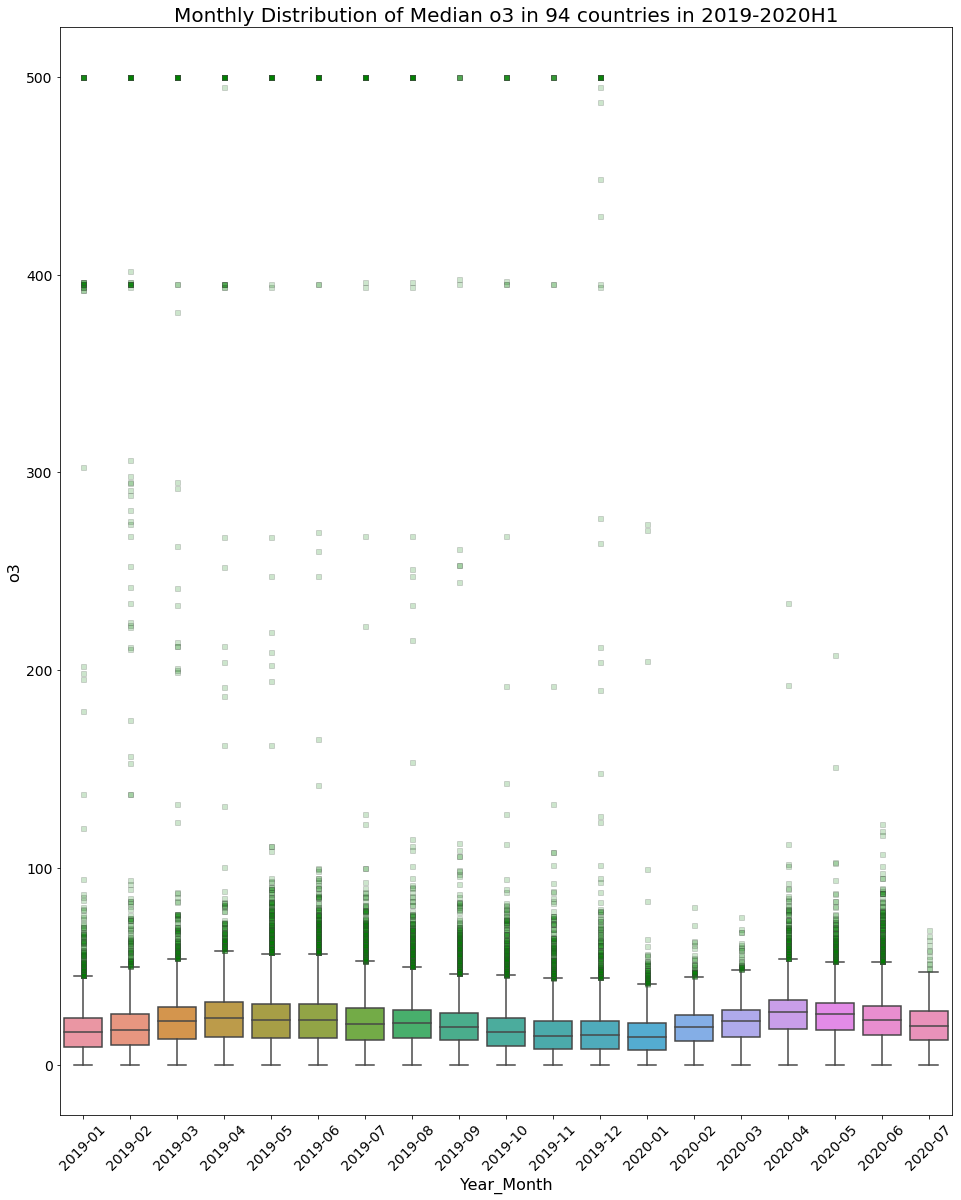

In [72]:
specie_boxplot("o3")

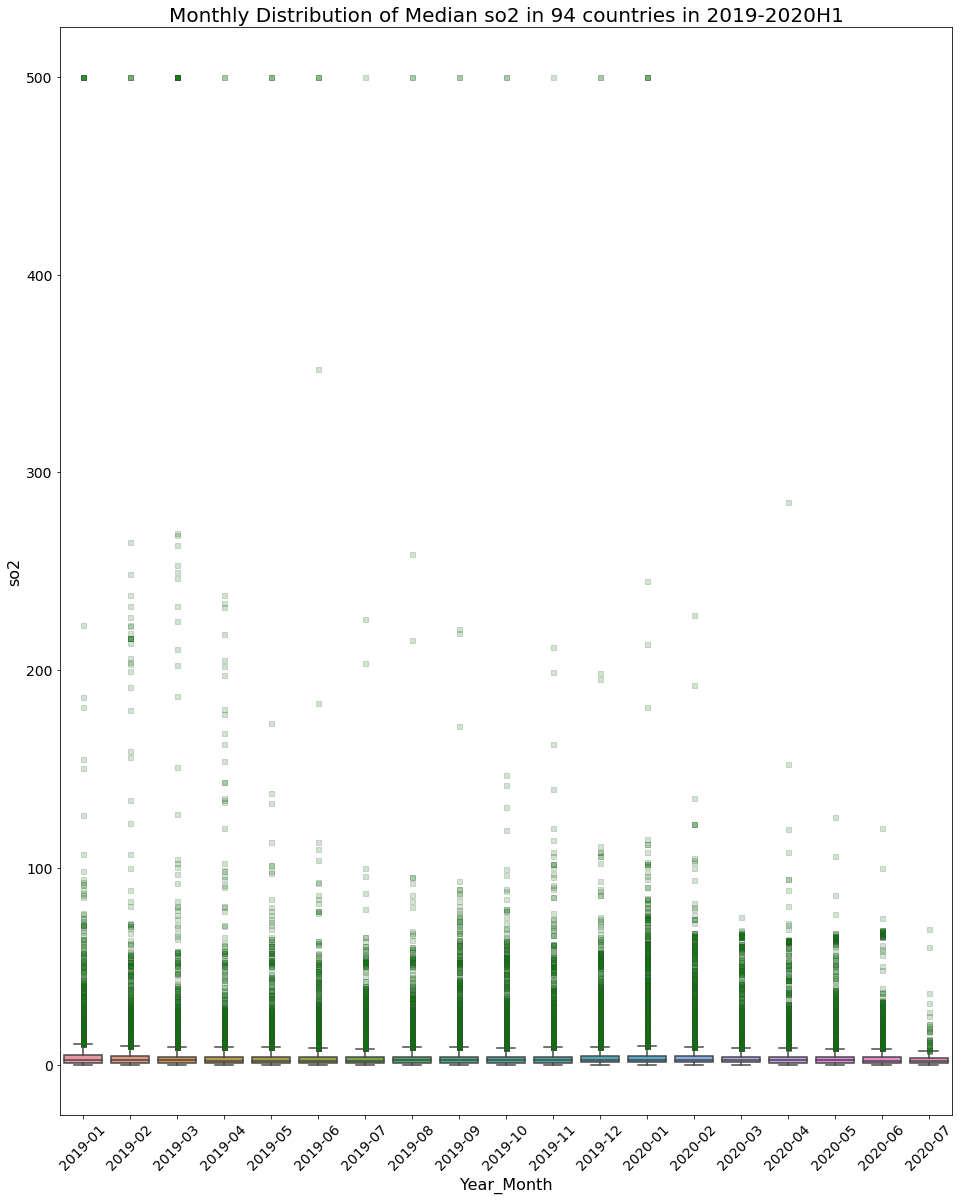

In [73]:
specie_boxplot("so2")

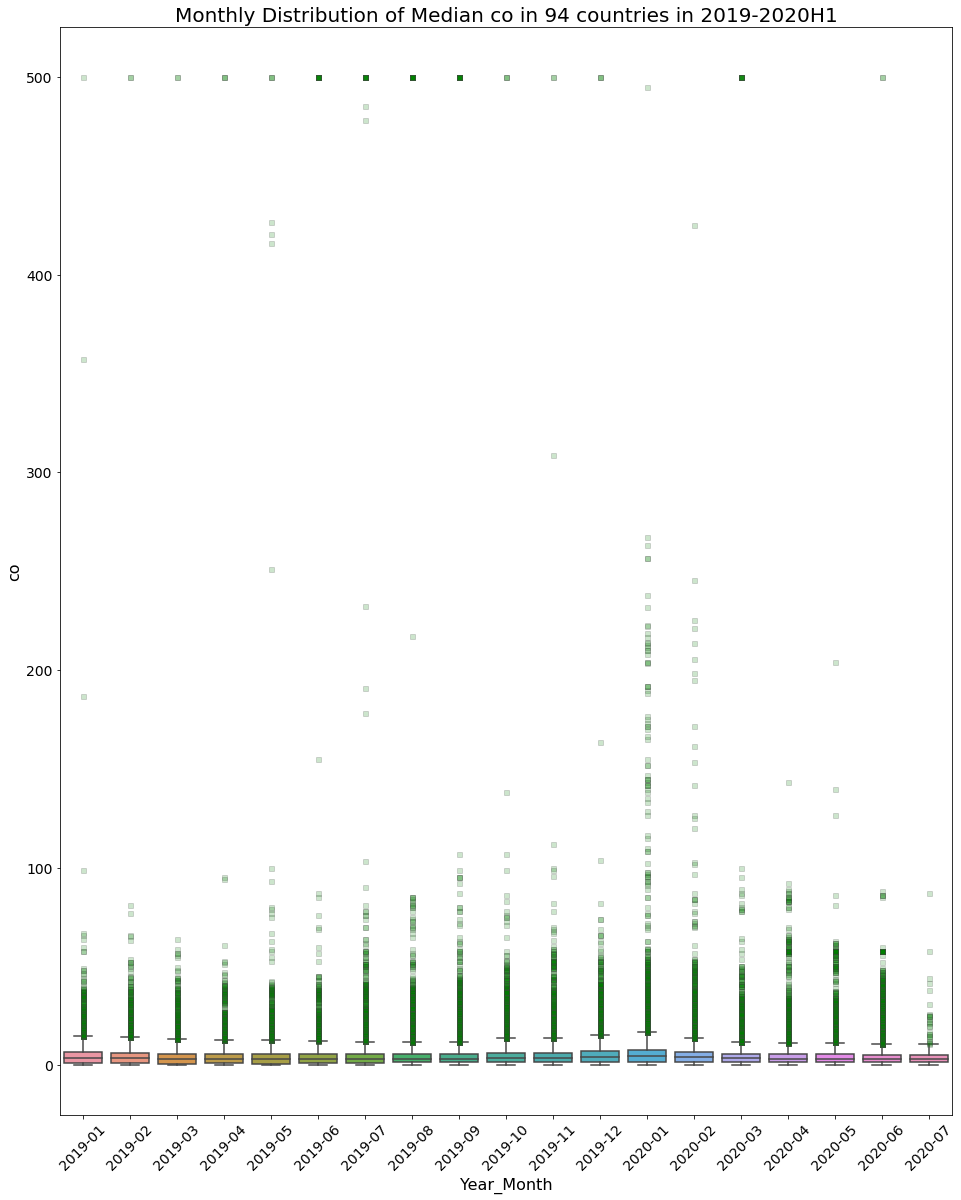

In [74]:
specie_boxplot("co")

## Covid-19 Dataset

In [77]:
# Use the following api to get the country name, country code and slug
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

[{'Country': 'Colombia', 'ISO2': 'CO', 'Slug': 'colombia'},
 {'Country': 'Norway', 'ISO2': 'NO', 'Slug': 'norway'},
 {'Country': 'Palau', 'ISO2': 'PW', 'Slug': 'palau'},
 {'Country': 'Bulgaria', 'ISO2': 'BG', 'Slug': 'bulgaria'},
 {'Country': 'San Marino', 'ISO2': 'SM', 'Slug': 'san-marino'},
 {'Country': 'Sudan', 'ISO2': 'SD', 'Slug': 'sudan'},
 {'Country': 'Zimbabwe', 'ISO2': 'ZW', 'Slug': 'zimbabwe'},
 {'Country': 'Mozambique', 'ISO2': 'MZ', 'Slug': 'mozambique'},
 {'Country': 'Senegal', 'ISO2': 'SN', 'Slug': 'senegal'},
 {'Country': 'Jamaica', 'ISO2': 'JM', 'Slug': 'jamaica'},
 {'Country': 'Seychelles', 'ISO2': 'SC', 'Slug': 'seychelles'},
 {'Country': 'Ghana', 'ISO2': 'GH', 'Slug': 'ghana'},
 {'Country': 'Liberia', 'ISO2': 'LR', 'Slug': 'liberia'},
 {'Country': 'Pakistan', 'ISO2': 'PK', 'Slug': 'pakistan'},
 {'Country': 'Thailand', 'ISO2': 'TH', 'Slug': 'thailand'},
 {'Country': 'Timor-Leste', 'ISO2': 'TL', 'Slug': 'timor-leste'},
 {'Country': 'Turkmenistan', 'ISO2': 'TM', 'Slug':

In [78]:
# Create the country code dataframe
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

Country                              Slug ISO2
0                        Colombia                          colombia   CO
1                          Norway                            norway   NO
2                           Palau                             palau   PW
3                        Bulgaria                          bulgaria   BG
4                      San Marino                        san-marino   SM
..                            ...                               ...  ...
243                   New Zealand                       new-zealand   NZ
244      Northern Mariana Islands          northern-mariana-islands   MP
245  Saint Vincent and Grenadines  saint-vincent-and-the-grenadines   VC
246                      Slovakia                          slovakia   SK
247                     Sri Lanka                         sri-lanka   LK

[248 rows x 3 columns]

In [79]:
# The country code is used to merge with the air quality data (with country code only)
final_air_df = pd.merge(clean_air_df, country_covid_df, how="inner",
                        left_on="Country", right_on="ISO2", suffixes=("_code", "_name"))
final_air_df.head(10)

Date Country_code       City Specie  count    min    max  median  \
0 2019-01-16           AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1 2019-01-22           AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
2 2019-01-26           AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
3 2019-07-01           AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
4 2019-10-01           AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   
5 2019-01-14           AE  Abu Dhabi   pm10     24   65.0   76.0    74.0   
6 2019-01-15           AE  Abu Dhabi   pm10     24   76.0   97.0    83.0   
7 2019-01-21           AE  Abu Dhabi   pm10     24   52.0   59.0    58.0   
8 2019-08-01           AE  Abu Dhabi   pm10     24   92.0   98.0    97.0   
9 2019-01-17           AE  Abu Dhabi   pm10     24   74.0   85.0    77.0   

   variance          Country_name                  Slug ISO2  
0    179.40  United Arab Emirates  united-arab-emirates   AE  
1     23.75  United Arab Emirates  united-arab-emirates   AE  
2    941.96  United Arab Emirates  united-arab-emirates   AE  
3   1006.88  United Arab Emirates  united-arab-emirates   AE  
4     57.97  United Arab Emirates  united-arab-emirates   AE  
5     88.68  United Arab Emirates  united-arab-emirates   AE  
6    637.66  United Arab Emirates  united-arab-emirates   AE  
7     69.98  United Arab Emirates  united-arab-emirates   AE  
8     26.79  United Arab Emirates  united-arab-emirates   AE  
9    199.55  United Arab Emirates  united-arab-emirates   AE

In [80]:
# Delete the ISO2 which is identical to the country_code column
del final_air_df["ISO2"]
final_air_df.head()

Date Country_code       City Specie  count    min    max  median  \
0 2019-01-16           AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1 2019-01-22           AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
2 2019-01-26           AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
3 2019-07-01           AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
4 2019-10-01           AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

   variance          Country_name                  Slug  
0    179.40  United Arab Emirates  united-arab-emirates  
1     23.75  United Arab Emirates  united-arab-emirates  
2    941.96  United Arab Emirates  united-arab-emirates  
3   1006.88  United Arab Emirates  united-arab-emirates  
4     57.97  United Arab Emirates  united-arab-emirates

In [81]:
final_air_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518183 entries, 0 to 1518182
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1518183 non-null  datetime64[ns]
 1   Country_code  1518183 non-null  object        
 2   City          1518183 non-null  object        
 3   Specie        1518183 non-null  object        
 4   count         1518183 non-null  int64         
 5   min           1518183 non-null  float64       
 6   max           1518183 non-null  float64       
 7   median        1518183 non-null  float64       
 8   variance      1518183 non-null  float64       
 9   Country_name  1518183 non-null  object        
 10  Slug          1518183 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 139.0+ MB


In [82]:
# number of countries
slug_list = final_air_df["Slug"].unique().tolist()
len(slug_list)

93

In [84]:
# Use the slug list to loop through the Covid-19 API by all case status for each country.
base_covid_url = "https://api.covid19api.com/total/country/"

country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:

    try:
        response = requests.get(base_covid_url + slug).json()

        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

Beginning Data Retrieval
-----------------------------------
Processing Record 1 of Set 1 | united-arab-emirates
Processing Record 2 of Set 1 | czech-republic
Processing Record 3 of Set 1 | singapore
Processing Record 4 of Set 1 | austria
Processing Record 5 of Set 1 | belgium
Processing Record 6 of Set 1 | korea-south
Processing Record 7 of Set 1 | mongolia
Processing Record 8 of Set 1 | norway
Processing Record 9 of Set 1 | nepal
Processing Record 10 of Set 1 | peru
Processing Record 11 of Set 1 | bosnia-and-herzegovina
Processing Record 12 of Set 1 | brazil
Processing Record 13 of Set 1 | israel
Processing Record 14 of Set 1 | india
Processing Record 15 of Set 1 | iran
Processing Record 16 of Set 1 | new-zealand
Processing Record 17 of Set 1 | ukraine
Processing Record 18 of Set 1 | united-states
Processing Record 19 of Set 1 | france
Processing Record 20 of Set 1 | kuwait
Processing Record 21 of Set 1 | réunion
Processing Record 22 of Set 1 | turkey
Processing Record 23 of Set 1 | 

In [85]:
# Create the world covid dataframe
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

Country                  Date  Active cases  Confirmed cases  \
0  United Arab Emirates  2020-01-22T00:00:00Z             0                0   
1  United Arab Emirates  2020-01-23T00:00:00Z             0                0   
2  United Arab Emirates  2020-01-24T00:00:00Z             0                0   
3  United Arab Emirates  2020-01-25T00:00:00Z             0                0   
4  United Arab Emirates  2020-01-26T00:00:00Z             0                0   

   Recovered cases  Deaths  
0                0       0  
1                0       0  
2                0       0  
3                0       0  
4                0       0

In [86]:
# Overview of the covid dataframe
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75768 entries, 0 to 75767
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          75768 non-null  object
 1   Date             75768 non-null  object
 2   Active cases     75768 non-null  int64 
 3   Confirmed cases  75768 non-null  int64 
 4   Recovered cases  75768 non-null  int64 
 5   Deaths           75768 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.5+ MB


In [87]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [88]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

Timestamp('2020-01-22 00:00:00')

In [89]:
# Find the latest date the covid dataset covers:
covid_df["Date"].max()

Timestamp('2022-05-31 00:00:00')

In [90]:
# Set cutoff date to the 1st July 2020
world_covid_df = covid_df[covid_df["Date"] <= end_date]

In [91]:
# Check the number of unique countries in the world_covid_df
covid_df["Country"].nunique()

88

In [92]:
# Export the list of countries that are shared by the air data and world covid data
air_covid_common_country_list = covid_df["Country"].unique().tolist()
air_covid_common_country_list

['United Arab Emirates',
 'Czech Republic',
 'Singapore',
 'Austria',
 'Belgium',
 'Korea (South)',
 'Mongolia',
 'Norway',
 'Nepal',
 'Peru',
 'Bosnia and Herzegovina',
 'Brazil',
 'Israel',
 'India',
 'Iran, Islamic Republic of',
 'New Zealand',
 'Ukraine',
 'United States of America',
 'France',
 'Kuwait',
 'Turkey',
 'Republic of Kosovo',
 'Uzbekistan',
 'Finland',
 'Japan',
 'Kazakhstan',
 'Romania',
 'Russian Federation',
 'Slovakia',
 'Spain',
 'Croatia',
 'Thailand',
 'Sri Lanka',
 'Argentina',
 'Canada',
 'Switzerland',
 'Chile',
 'Ethiopia',
 'Kyrgyzstan',
 'Germany',
 'Mexico',
 'Saudi Arabia',
 'Uganda',
 'Bangladesh',
 'Hungary',
 'Iceland',
 'Philippines',
 'Indonesia',
 'Sweden',
 'El Salvador',
 'Viet Nam',
 'Australia',
 'Bahrain',
 'United Kingdom',
 'Ireland',
 'Lao PDR',
 'Lithuania',
 'Portugal',
 'Taiwan, Republic of China',
 'China',
 'Poland',
 'Bulgaria',
 'Cyprus',
 'Iraq',
 'Macedonia, Republic of',
 'Bolivia',
 'Denmark',
 'Ecuador',
 'South Africa',
 'Colom

In [93]:
# Filter out the air quality data to contain only the above countries
final_clean_air_df = final_air_df[final_air_df["Country_name"].isin(
    air_covid_common_country_list)]
final_clean_air_df.head()

Date Country_code       City Specie  count    min    max  median  \
0 2019-01-16           AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1 2019-01-22           AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
2 2019-01-26           AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
3 2019-07-01           AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
4 2019-10-01           AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

   variance          Country_name                  Slug  
0    179.40  United Arab Emirates  united-arab-emirates  
1     23.75  United Arab Emirates  united-arab-emirates  
2    941.96  United Arab Emirates  united-arab-emirates  
3   1006.88  United Arab Emirates  united-arab-emirates  
4     57.97  United Arab Emirates  united-arab-emirates

In [94]:
# Double check the number of countries in the final clean air data
final_clean_air_df["Country_name"].nunique()

88

In [95]:
del final_clean_air_df["Slug"]
final_clean_air_df.head()

Date Country_code       City Specie  count    min    max  median  \
0 2019-01-16           AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1 2019-01-22           AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
2 2019-01-26           AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
3 2019-07-01           AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
4 2019-10-01           AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

   variance          Country_name  
0    179.40  United Arab Emirates  
1     23.75  United Arab Emirates  
2    941.96  United Arab Emirates  
3   1006.88  United Arab Emirates  
4     57.97  United Arab Emirates

In [96]:
# Export the air data to csv file for future use
final_clean_air_df.to_csv("output/clean_world_air.csv", index=False)

# Visualisation

In [97]:
covid_df.head()

Country       Date  Active cases  Confirmed cases  \
0  United Arab Emirates 2020-01-22             0                0   
1  United Arab Emirates 2020-01-23             0                0   
2  United Arab Emirates 2020-01-24             0                0   
3  United Arab Emirates 2020-01-25             0                0   
4  United Arab Emirates 2020-01-26             0                0   

   Recovered cases  Deaths  
0                0       0  
1                0       0  
2                0       0  
3                0       0  
4                0       0

In [98]:
# Filter out the world covid data with active cases
world_active_covid = covid_df[[
    "Date", "Country", "Active cases"]].sort_values("Date").copy()
world_active_covid.head()

Date               Country  Active cases
0     2020-01-22  United Arab Emirates             0
19803 2020-01-22               Finland             0
20664 2020-01-22                 Japan             2
21525 2020-01-22            Kazakhstan             0
22386 2020-01-22               Romania             0

In [99]:
# Get the world covid active case data on the 20th April 2020
april20_world_active_covid = world_active_covid[world_active_covid["Date"] == "2020-04-20"].copy()

In [100]:
# Check the number of countries covered in the world covid active case data on the 1st July 2020
april20_world_active_covid["Country"].nunique()

88

In [101]:
# Visualise the 85 countries covered in our analysis in an interactive choropleth map

figure = px.choropleth(april20_world_active_covid, 
                       locations="Country",
                       locationmode="country names", 
                       color="Active cases",
                       hover_name="Country",
                       color_continuous_scale="bupu", 
                       range_color=[200, 10000], 
                       title=f'{april20_world_active_covid["Country"].nunique()} Countries with Number of Covid-19 Active Cases On 20th April 2020')
figure.show()

## 9adech kol country fiha men cas kol nhar 

In [102]:
# Transpose the 85 countries to columns
world_active_covid_transposed = world_active_covid.pivot_table(
    index="Date", columns="Country", values="Active cases")
world_active_covid_transposed.head()

Country     Afghanistan  Algeria  Argentina  Australia  Austria  Bahrain  \
Date                                                                       
2020-01-22            0        0          0          0        0        0   
2020-01-23            0        0          0          0        0        0   
2020-01-24            0        0          0          0        0        0   
2020-01-25            0        0          0          0        0        0   
2020-01-26            0        0          0          4        0        0   

Country     Bangladesh  Belgium  Bolivia  Bosnia and Herzegovina  ...  \
Date                                                              ...   
2020-01-22           0        0        0                       0  ...   
2020-01-23           0        0        0                       0  ...   
2020-01-24           0        0        0                       0  ...   
2020-01-25           0        0        0                       0  ...   
2020-01-26           0        0        0                       0  ...   

Country     Tajikistan  Thailand  Turkey  Uganda  Ukraine  \
Date                                                        
2020-01-22           0         2       0       0        0   
2020-01-23           0         2       0       0        0   
2020-01-24           0         2       0       0        0   
2020-01-25           0         3       0       0        0   
2020-01-26           0         2       0       0        0   

Country     United Arab Emirates  United Kingdom  United States of America  \
Date                                                                         
2020-01-22                     0               0                         1   
2020-01-23                     0               0                         1   
2020-01-24                     0               0                         2   
2020-01-25                     0               0                         2   
2020-01-26                     0               0                         5   

Country     Uzbekistan  Viet Nam  
Date                              
2020-01-22           0         0  
2020-01-23           0         2  
2020-01-24           0         2  
2020-01-25           0         2  
2020-01-26           0         2  

[5 rows x 88 columns]

In [103]:
# Calculate the total active cases for the 85 countries on each Date
world_active_covid_transposed["Total active cases"] = world_active_covid_transposed.sum(axis=1)
world_active_covid_transposed.head()

Country     Afghanistan  Algeria  Argentina  Australia  Austria  Bahrain  \
Date                                                                       
2020-01-22            0        0          0          0        0        0   
2020-01-23            0        0          0          0        0        0   
2020-01-24            0        0          0          0        0        0   
2020-01-25            0        0          0          0        0        0   
2020-01-26            0        0          0          4        0        0   

Country     Bangladesh  Belgium  Bolivia  Bosnia and Herzegovina  ...  \
Date                                                              ...   
2020-01-22           0        0        0                       0  ...   
2020-01-23           0        0        0                       0  ...   
2020-01-24           0        0        0                       0  ...   
2020-01-25           0        0        0                       0  ...   
2020-01-26           0        0        0                       0  ...   

Country     Thailand  Turkey  Uganda  Ukraine  United Arab Emirates  \
Date                                                                  
2020-01-22         2       0       0        0                     0   
2020-01-23         2       0       0        0                     0   
2020-01-24         2       0       0        0                     0   
2020-01-25         3       0       0        0                     0   
2020-01-26         2       0       0        0                     0   

Country     United Kingdom  United States of America  Uzbekistan  Viet Nam  \
Date                                                                         
2020-01-22               0                         1           0         0   
2020-01-23               0                         1           0         2   
2020-01-24               0                         2           0         2   
2020-01-25               0                         2           0         2   
2020-01-26               0                         5           0         2   

Country     Total active cases  
Date                            
2020-01-22                 510  
2020-01-23                 607  
2020-01-24                 879  
2020-01-25                1349  
2020-01-26                2004  

[5 rows x 89 columns]

In [104]:
# Get and export the covid Total active case data for the 85 countries
total_active_world_covid = world_active_covid_transposed["Total active cases"].to_frame().reset_index()
total_active_world_covid.to_csv("output/active_world_covid.csv", index=False)
total_active_world_covid.head()

Date  Total active cases
0 2020-01-22                 510
1 2020-01-23                 607
2 2020-01-24                 879
3 2020-01-25                1349
4 2020-01-26                2004

In [105]:
# Get and export the covid active case data for Australia
au_covid = world_active_covid[world_active_covid["Country"] == "United States of America"].copy()
au_covid.head()

Date                   Country  Active cases
14637 2020-01-22  United States of America             1
14638 2020-01-23  United States of America             1
14639 2020-01-24  United States of America             2
14640 2020-01-25  United States of America             2
14641 2020-01-26  United States of America             5

In [106]:
au_covid.to_csv("output/active_au_covid.csv", index=False)

## Visualization te3 US

In [107]:
# Import the air data for the 85 countries
world_air = pd.read_csv("output/clean_world_air.csv", parse_dates=True)
world_air.head()

Date Country_code       City Specie  count    min    max  median  \
0  2019-01-16           AE  Abu Dhabi   pm10     24   86.0   99.0    97.0   
1  2019-01-22           AE  Abu Dhabi   pm10     24   51.0   57.0    55.0   
2  2019-01-26           AE  Abu Dhabi   pm10     24  136.0  173.0   160.0   
3  2019-07-01           AE  Abu Dhabi   pm10     24   60.0   91.0    72.0   
4  2019-10-01           AE  Abu Dhabi   pm10     24   82.0   93.0    87.0   

   variance          Country_name  
0    179.40  United Arab Emirates  
1     23.75  United Arab Emirates  
2    941.96  United Arab Emirates  
3   1006.88  United Arab Emirates  
4     57.97  United Arab Emirates

In [108]:
# Change the data type of the Date column into datetime
world_air['Date'] = world_air['Date'].astype('datetime64[ns]')

In [109]:
# Import the covid data total active cases for the 85 countries 
active_world_covid = pd.read_csv("output/active_world_covid.csv", parse_dates=True)
active_world_covid.head()

Date  Total active cases
0  2020-01-22                 510
1  2020-01-23                 607
2  2020-01-24                 879
3  2020-01-25                1349
4  2020-01-26                2004

In [110]:
# Change the data type of the Date column into datetime
active_world_covid['Date'] = active_world_covid['Date'].astype('datetime64[ns]')

In [111]:
# Filter the air data for United States
au_air_df = world_air[world_air["Country_code"]=="US"].copy()
au_air_df.head()
au_covid.to_csv("output/active_united_states_covid.csv", index=False)

In [112]:
# Import the covid active case data for US
active_us_covid = pd.read_csv("output/active_united_states_covid.csv", parse_dates=True)
active_us_covid.head()

Date                   Country  Active cases
0  2020-01-22  United States of America             1
1  2020-01-23  United States of America             1
2  2020-01-24  United States of America             2
3  2020-01-25  United States of America             2
4  2020-01-26  United States of America             5

In [120]:
# active_us_covid['Date'] = active_au_covid['Date'].astype('datetime64[ns]')
active_us_covid['Date'] = pd.to_datetime(active_us_covid['Date'], infer_datetime_format=True)


In [121]:
# Filter the air data for Australia
us_air_df = world_air[world_air["Country_code"]=="US"].copy()
us_air_df.head()

Date Country_code           City Specie  count   min   max  \
289097 2019-04-01           US  Oklahoma City   pm10     95   2.0  30.0   
289098 2019-01-31           US  Oklahoma City   pm10     96  11.0  63.0   
289099 2019-09-02           US  Oklahoma City   pm10     93   5.0  29.0   
289100 2019-03-29           US  Oklahoma City   pm10     94   8.0  56.0   
289101 2019-01-22           US  Oklahoma City   pm10     94   7.0  39.0   

        median  variance              Country_name  
289097    11.0    372.95  United States of America  
289098    23.0    801.37  United States of America  
289099    11.0    358.75  United States of America  
289100    17.0    772.25  United States of America  
289101    13.0    299.41  United States of America

In [122]:
# Filter out the clean_air_df part of Las Vegas
lv_air_df = clean_air_df.loc[(clean_air_df["Country"] == "US") & (
    clean_air_df["City"] == "Las Vegas")].sort_values("Date").set_index("Date")
lv_air_df.head()

Country       City Specie  count  min   max  median  variance
Date                                                                    
2019-01-01      US  Las Vegas     co    140  0.1   0.1     0.1      0.00
2019-01-01      US  Las Vegas     o3    131  2.5  15.1    13.0     75.90
2019-01-01      US  Las Vegas   pm25    168  5.0  40.0    14.0    626.72
2019-01-01      US  Las Vegas   pm10    168  3.0  25.0     9.0    152.93
2019-01-01      US  Las Vegas    no2    163  1.3   7.3     2.1     16.05

In [123]:
# Overview of the air pollutants appearing in the Las Vegas air quality data
lv_air_df["Specie"].value_counts()

o3      551
pm25    551
pm10    551
co      550
no2     550
so2     519
Name: Specie, dtype: int64

In [141]:
# Define a function plotting air pollutant changes in Las Vegas using the rolling windows
# Rolling windows overlap and "roll" along at the same frequency as the data.
# Therefore, the transformed time series is at the same frequency as the original ones.


def lv_air_specie(specie):
    specie_lv_air = lv_air_df[lv_air_df["Specie"] == specie]
    rolling_median_specie_lv_air = specie_lv_air["median"].rolling(
        30, center=True).mean()
    rolling_median_specie_lv_air.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.axvspan("2020-03", "2020-07", color='black', alpha=0.1)
    plt.axvspan("2019-03", "2019-07", color='blue', alpha=0.1)

    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"Average of Median {specie} values in Las vegas in 2019-2020H1", fontsize=14)

    plt.savefig(f"images/las_vegas_{specie}.png")

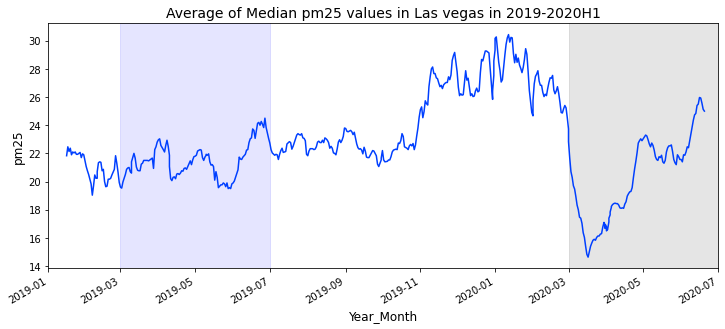

In [142]:
lv_air_specie("pm25")

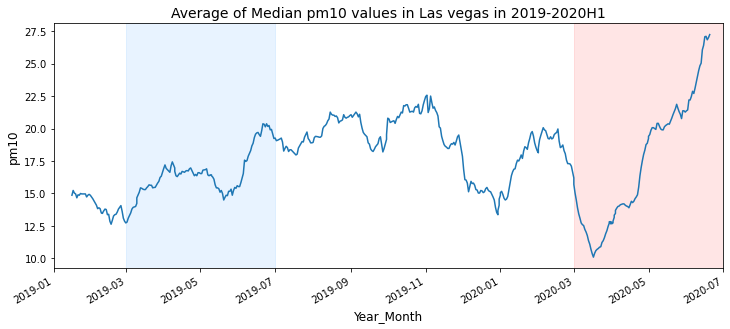

In [127]:
lv_air_specie("pm10")

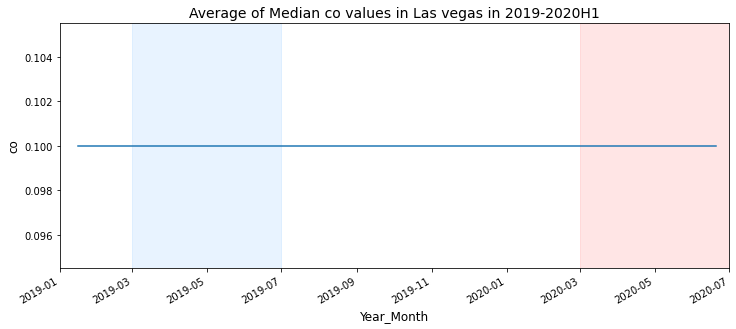

In [128]:
lv_air_specie("co")

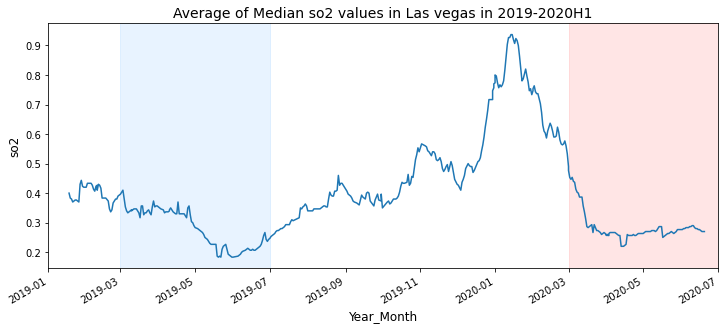

In [129]:
lv_air_specie("so2")

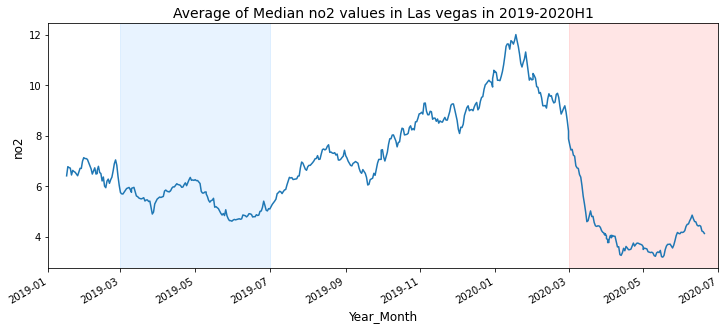

In [130]:
lv_air_specie("no2")

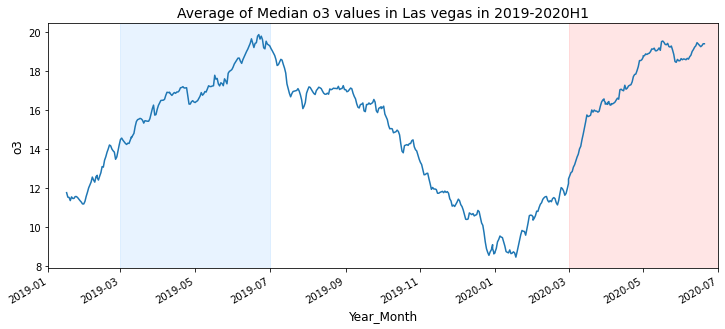

In [131]:
lv_air_specie("o3")

In [132]:
# Define a function plotting air pollutant changes in different cities using the rolling windows


def specie_cities(df, city_list, specie):

    specie_cities_df = df[(df["City"].isin(city_list)) & (
        df["Specie"] == specie)].sort_values("Date").copy()
    specie_cities_transposed_df = specie_cities_df.pivot_table(
        index="Date", columns="City", values="median")
    rolling_specie_cities = specie_cities_transposed_df[city_list].rolling(
        7, center=True).mean()

    plt.style.use('seaborn-bright')
    rolling_specie_cities.plot(figsize=(12, 5))

    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.axvspan("2020-03", "2020-07", color='red', alpha=0.1)
    plt.axvspan("2019-03", "2019-07", color='dodgerblue', alpha=0.1)

    plt.ylabel(specie, fontsize=12)
    plt.title(
        f"Average of median {specie} in {city_list} in 2019-2020H1", fontsize=14)
    plt.savefig(f"images/{city_list}_{specie}.png")

In [133]:
# Filter out air quality data for US

au_air_df = clean_air_df.loc[clean_air_df["Country"] == "US"]
au_air_df.head()

Date Country           City Specie  count   min   max  median  \
1689129 2019-04-01      US  Oklahoma City   pm10     95   2.0  30.0    11.0   
1689130 2019-01-31      US  Oklahoma City   pm10     96  11.0  63.0    23.0   
1689131 2019-09-02      US  Oklahoma City   pm10     93   5.0  29.0    11.0   
1689132 2019-03-29      US  Oklahoma City   pm10     94   8.0  56.0    17.0   
1689133 2019-01-22      US  Oklahoma City   pm10     94   7.0  39.0    13.0   

         variance  
1689129    372.95  
1689130    801.37  
1689131    358.75  
1689132    772.25  
1689133    299.41

In [134]:
au_cities_list = ["Las Vegas", "Atlanta"]

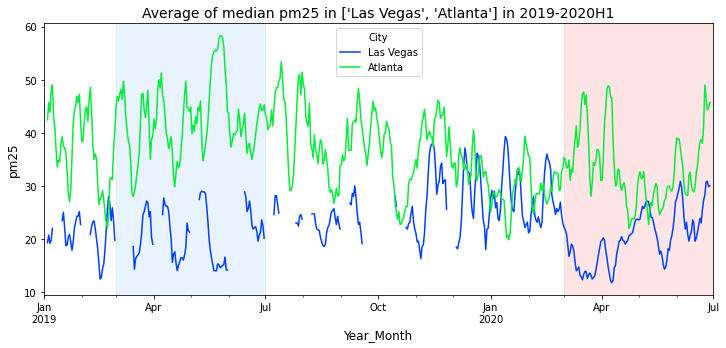

In [135]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="pm25")

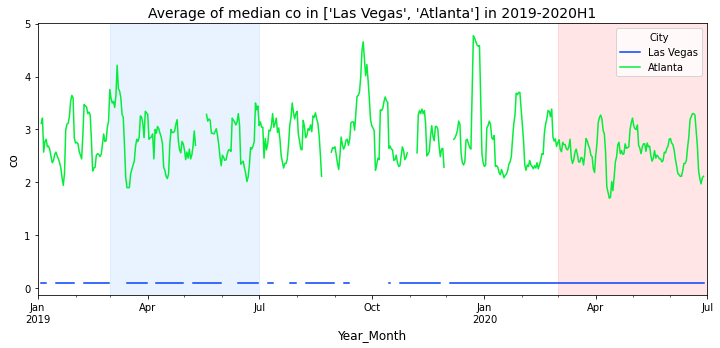

In [136]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="co")

# Fusion

## Air

In [251]:
air_dataset = clean_air_df_transposed
air_dataset.shape

(307832, 10)

In [252]:
air_dataset.tail()

Specie       Date Country            City   co  no2   o3  pm10   pm25  so2  \
307827 2020-07-01      ZA  Port Elizabeth  4.7  3.7  9.4  24.0   38.0  0.6   
307828 2020-07-01      ZA        Pretoria  3.3  9.6  NaN  53.0   95.0  2.5   
307829 2020-07-01      ZA    Richards Bay  NaN  1.9  NaN  10.0   21.0  1.9   
307830 2020-07-01      ZA     Vereeniging  5.9  6.0  6.1  57.0  119.0  3.6   
307831 2020-07-01      ZA       Worcester  1.4  6.0  0.9  31.0   63.0  7.6   

Specie year_month  
307827    2020-07  
307828    2020-07  
307829    2020-07  
307830    2020-07  
307831    2020-07

In [255]:
air_dataset = air_dataset.rename(columns={"Country":"Code"})
air_dataset.tail()

Specie       Date Code            City   co  no2   o3  pm10   pm25  so2  \
307827 2020-07-01   ZA  Port Elizabeth  4.7  3.7  9.4  24.0   38.0  0.6   
307828 2020-07-01   ZA        Pretoria  3.3  9.6  NaN  53.0   95.0  2.5   
307829 2020-07-01   ZA    Richards Bay  NaN  1.9  NaN  10.0   21.0  1.9   
307830 2020-07-01   ZA     Vereeniging  5.9  6.0  6.1  57.0  119.0  3.6   
307831 2020-07-01   ZA       Worcester  1.4  6.0  0.9  31.0   63.0  7.6   

Specie year_month  
307827    2020-07  
307828    2020-07  
307829    2020-07  
307830    2020-07  
307831    2020-07

## Covid

In [256]:
covid_dataset = world_covid_df
covid_dataset.shape

(14256, 6)

In [257]:
covid_dataset

Country       Date  Active cases  Confirmed cases  \
0      United Arab Emirates 2020-01-22             0                0   
1      United Arab Emirates 2020-01-23             0                0   
2      United Arab Emirates 2020-01-24             0                0   
3      United Arab Emirates 2020-01-25             0                0   
4      United Arab Emirates 2020-01-26             0                0   
...                     ...        ...           ...              ...   
75064                 Ghana 2020-06-27          4071            16431   
75065                 Ghana 2020-06-28          3910            16742   
75066                 Ghana 2020-06-29          4245            17351   
75067                 Ghana 2020-06-30          4361            17741   
75068                 Ghana 2020-07-01          4467            18134   

       Recovered cases  Deaths  
0                    0       0  
1                    0       0  
2                    0       0  
3                    0       0  
4                    0       0  
...                ...     ...  
75064            12257     103  
75065            12720     112  
75066            12994     112  
75067            13268     112  
75068            13550     117  

[14256 rows x 6 columns]

## Countries Codes

In [258]:
countries_codes_df = pd.read_csv('countries_code.csv')

In [259]:
countries_codes_df.head()

Country Code
0     Afghanistan   AF
1   Åland Islands   AX
2         Albania   AL
3         Algeria   DZ
4  American Samoa   AS

In [260]:
# Add code to each country
covid_dataset = pd.merge(covid_dataset, countries_codes_df, on='Country')
covid_dataset

Country       Date  Active cases  Confirmed cases  \
0      United Arab Emirates 2020-01-22             0                0   
1      United Arab Emirates 2020-01-23             0                0   
2      United Arab Emirates 2020-01-24             0                0   
3      United Arab Emirates 2020-01-25             0                0   
4      United Arab Emirates 2020-01-26             0                0   
...                     ...        ...           ...              ...   
14251                 Ghana 2020-06-27          4071            16431   
14252                 Ghana 2020-06-28          3910            16742   
14253                 Ghana 2020-06-29          4245            17351   
14254                 Ghana 2020-06-30          4361            17741   
14255                 Ghana 2020-07-01          4467            18134   

       Recovered cases  Deaths Code  
0                    0       0   AE  
1                    0       0   AE  
2                    0       0   AE  
3                    0       0   AE  
4                    0       0   AE  
...                ...     ...  ...  
14251            12257     103   GH  
14252            12720     112   GH  
14253            12994     112   GH  
14254            13268     112   GH  
14255            13550     117   GH  

[14256 rows x 7 columns]

## Merge Covid dataset and air quality dataset

In [263]:
merged_dataset = pd.merge(covid_dataset, air_dataset, on=['Date','Code'])
merged_dataset

Country       Date  Active cases  Confirmed cases  \
0      United Arab Emirates 2020-01-22             0                0   
1      United Arab Emirates 2020-01-22             0                0   
2      United Arab Emirates 2020-01-23             0                0   
3      United Arab Emirates 2020-01-23             0                0   
4      United Arab Emirates 2020-01-24             0                0   
...                     ...        ...           ...              ...   
94265                 Ghana 2020-06-27          4071            16431   
94266                 Ghana 2020-06-28          3910            16742   
94267                 Ghana 2020-06-29          4245            17351   
94268                 Ghana 2020-06-30          4361            17741   
94269                 Ghana 2020-07-01          4467            18134   

       Recovered cases  Deaths Code       City   co   no2    o3   pm10  pm25  \
0                    0       0   AE  Abu Dhabi  0.1  28.8  16.3   42.0  42.0   
1                    0       0   AE      Dubai  NaN   NaN  14.7    NaN  76.0   
2                    0       0   AE  Abu Dhabi  0.1  12.8  18.7   63.0  61.0   
3                    0       0   AE      Dubai  NaN   NaN  14.3    NaN  63.0   
4                    0       0   AE  Abu Dhabi  0.1   5.5  28.9  106.0  21.0   
...                ...     ...  ...        ...  ...   ...   ...    ...   ...   
94265            12257     103   GH      Accra  NaN   NaN   NaN    NaN  55.0   
94266            12720     112   GH      Accra  NaN   NaN   NaN    NaN  59.0   
94267            12994     112   GH      Accra  NaN   NaN   NaN    NaN  59.0   
94268            13268     112   GH      Accra  NaN   NaN   NaN    NaN  59.0   
94269            13550     117   GH      Accra  NaN   NaN   NaN    NaN  65.0   

       so2 year_month  
0      5.1    2020-01  
1      NaN    2020-01  
2      5.1    2020-01  
3      NaN    2020-01  
4      5.6    2020-01  
...    ...        ...  
94265  NaN    2020-06  
94266  NaN    2020-06  
94267  NaN    2020-06  
94268  NaN    2020-06  
94269  NaN    2020-07  

[94270 rows x 15 columns]

In [272]:
profile = ProfileReport(merged_dataset, title="Merged Profiling Report", explorative=True)

In [276]:
profile.to_widgets()

Render widgets:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Country       Date  Active cases  Confirmed cases  \
0  United Arab Emirates 2020-01-22             0                0   
1  United Arab Emirates 2020-01-22             0                0   
2  United Arab Emirates 2020-01-23             0                0   
3  United Arab Emirates 2020-01-23             0                0   
4  United Arab Emirates 2020-01-24             0                0   
5  United Arab Emirates 2020-01-24             0                0   
6  United Arab Emirates 2020-01-25             0                0   
7  United Arab Emirates 2020-01-25             0                0   
8  United Arab Emirates 2020-01-26             0                0   
9  United Arab Emirates 2020-01-26             0                0   

   Recovered cases  Deaths Code       City   co   no2    o3   pm10  pm25  so2  \
0                0       0   AE  Abu Dhabi  0.1  28.8  16.3   42.0  42.0  5.1   
1                0       0   AE      Dubai  NaN   NaN  14.7    NaN  76.0  NaN   
2                0       0   AE  Abu Dhabi  0.1  12.8  18.7   63.0  61.0  5.1   
3                0       0   AE      Dubai  NaN   NaN  14.3    NaN  63.0  NaN   
4                0       0   AE  Abu Dhabi  0.1   5.5  28.9  106.0  21.0  5.6   
5                0       0   AE      Dubai  NaN   NaN  16.7    NaN  42.0  NaN   
6                0       0   AE  Abu Dhabi  0.1  11.5  22.0   29.0  17.0  5.6   
7                0       0   AE      Dubai  NaN   NaN  17.5    NaN  46.0  NaN   
8                0       0   AE  Abu Dhabi  0.1   6.9  26.4   56.0  80.0  5.6   
9                0       0   AE      Dubai  NaN   NaN  17.1    NaN  53.0  NaN   

  year_month  
0    2020-01  
1    2020-01  
2    2020-01  
3    2020-01  
4    2020-01  
5    2020-01  
6    2020-01  
7    2020-01  
8    2020-01  
9    2020-01

Country       Date  Active cases  Confirmed cases  Recovered cases  \
94260   Ghana 2020-06-22          3596            14154            10473   
94261   Ghana 2020-06-23          3566            14568            10907   
94262   Ghana 2020-06-24          3840            15013            11078   
94263   Ghana 2020-06-25          3947            15473            11431   
94264   Ghana 2020-06-26          3976            15834            11755   
94265   Ghana 2020-06-27          4071            16431            12257   
94266   Ghana 2020-06-28          3910            16742            12720   
94267   Ghana 2020-06-29          4245            17351            12994   
94268   Ghana 2020-06-30          4361            17741            13268   
94269   Ghana 2020-07-01          4467            18134            13550   

       Deaths Code   City  co  no2  o3  pm10  pm25  so2 year_month  
94260      85   GH  Accra NaN  NaN NaN   NaN  72.0  NaN    2020-06  
94261      95   GH  Accra NaN  NaN NaN   NaN  78.0  NaN    2020-06  
94262      95   GH  Accra NaN  NaN NaN   NaN  74.0  NaN    2020-06  
94263      95   GH  Accra NaN  NaN NaN   NaN  70.0  NaN    2020-06  
94264     103   GH  Accra NaN  NaN NaN   NaN  65.0  NaN    2020-06  
94265     103   GH  Accra NaN  NaN NaN   NaN  55.0  NaN    2020-06  
94266     112   GH  Accra NaN  NaN NaN   NaN  59.0  NaN    2020-06  
94267     112   GH  Accra NaN  NaN NaN   NaN  59.0  NaN    2020-06  
94268     112   GH  Accra NaN  NaN NaN   NaN  59.0  NaN    2020-06  
94269     117   GH  Accra NaN  NaN NaN   NaN  65.0  NaN    2020-07